<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>


# Customize ZoneSpecies

<hr>
<small> For instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

In this tutorial we will:
* Introduce species into a Landlab model.
* Set the zones in which the species operate.
* Evolve a landscape and the species over time.
* Explore SpeciesEvolver output data structures.

The configuration of the model in this tutorial loosely follows the fault throw experiment in Lyons et al., in preperation for Earth Surface Dynamics.

## Macroevolution processes built into species

The evolution of the base species is driven by three processes.

### Dispersal: geographic range expansion

ZoneSpecies has two dispersal methods.

`_init_dispersal`: this method determines where species can redistribute given the conditions of the zone_func. Consider that `_init_dispersal` figures out where species can go, barring any conflicting conditions with other species. This method is more complicated, not designed to be modified as often

`_evaluate_dispersal`: the default of this method is that the dispersal of the species determined by `_init_dispersal` is 

### Speciation: lineage splitting

### Extinction: lineage termination


### Evaluation order

The potential dispersal of all species are first determined. Then the dispersal, speciation, and extinction of each species is evaluated in sequence.

These processes are run:
```python
for a_species in all_species:
    a_species._init_dispersal()
 
for a_species in all_species:
    a_species._evaluate_dispersal()
    a_species._evaluate_speciation() 
    a_species._evaluate_extinction() 
```

Import modules and set the environment to show plots inline in this notebook.

In [1]:
from landlab.components import SpeciesEvolver
from landlab.components.species_evolution import ZoneController, ZoneSpecies
from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

## Prepare the grid and components of the model.

Here we use code from the 'Introduction to SpeciesEvolver' tutorial. This code loads a model grid that has steady state topography and sets the top and bottom boundaries to open.

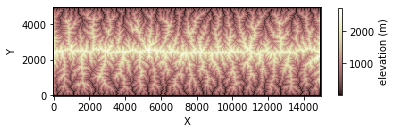

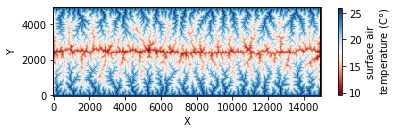

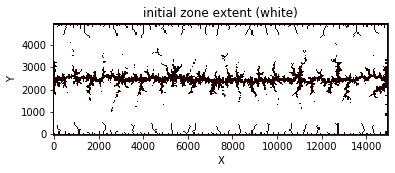

In [2]:
# Prepare the grid and components of the model.

(mg, z) = read_esri_ascii('model_grid_steady_state_elevation.txt')
mg.at_node['topographic__elevation'] = z
mg.set_closed_boundaries_at_grid_edges(right_is_closed=True,
                                       top_is_closed=False,
                                       left_is_closed=True,
                                       bottom_is_closed=False)

plt.figure()
imshow_grid(mg, z, colorbar_label='elevation (m)', shrink=0.4)

# Set surface temperature at sea level.

lapse_rate = -0.006
temperature_at_base_level = 26
T = lapse_rate * z + temperature_at_base_level
mg.add_field('node', 'land_surface_air__temperature', T)

# Plot temperature field.

plt.figure()
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='RdBu')

# Initialize SpeciesEvolver.

se = SpeciesEvolver(mg)

# Create a zone function and plot the initial zone extend.

def zone_func(grid):
    """Get a mask of the total zone extent."""
    T = grid.at_node['land_surface_air__temperature']
    T_max = 25
    T_min = 15
    zone_extent_mask = np.all([T >= T_min, T <= T_max], 0)
    return zone_extent_mask

sc = ZoneController(mg, zone_func, minimum_area=50000)

plt.figure()
imshow_grid(mg, zone_func(mg), plot_name='initial zone extent (white)',
            allow_colorbar=False)

## Customize ZoneSpecies

Default implementation of dispersal method:
```python
def _evaluate_dispersal(self, population):
    """Set the range of the species as it results from dispersal.

    The default implementation does not modify population dispersal in
    stage 1.

    Parameters
    ----------
    population : Population
        A population of the species.
    """
    ...  # pragma: no cover
```

In [3]:
class MySpecies(ZoneSpecies):
    def __init__(self, initial_zones, parent_species=None,
                 allopatric_wait_time=0, pseudoextinction=True):
        super(MySpecies, self).__init__(initial_zones, parent_species,
                                        allopatric_wait_time, pseudoextinction)
        
        # Set body size randomly.
        self.body_size = random.uniform(4, 400)
        
    #def _evaluate_dispersal(self, population):
    #    zone_species = population.zone.species
    #    zone_body_sizes = [s.body_size for s in zone_species]
    #    if self.body_size == max(zone_body_sizes):
    #        print('max_size', self.body_size, zone_body_sizes)
            
    def _evaluate_extinction(self, speciation_occurred):
        extinct_by_habitat_loss = super()._evaluate_extinction(speciation_occurred)
        extinct_by_size_probability = 
        return extinct_by_habitat_loss or extinct_by_size_probability

### Create a species that exists in the zone

In [4]:
species = sc.populate_zones_uniformly(1, species_type=MySpecies)
se.introduce_species(species)

# Display the species data frame.
se.species

,clade,number,time_appeared,latest_time
0,A,0,0,0
1,B,0,0,0


max_size 3.431604728310963 [3.431604728310963, 1.2034904150925987]


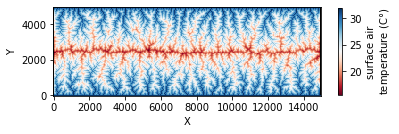

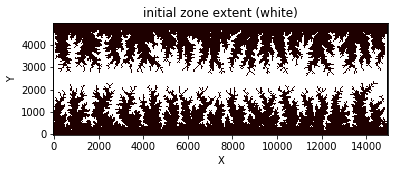

In [5]:
# Update the surface temperature field.
temperature_at_base_level = 32
mg.at_node['land_surface_air__temperature'] = lapse_rate * z + temperature_at_base_level

# Plot temperature field.
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='RdBu')
            
plt.figure()
imshow_grid(mg, zone_func(mg), plot_name='initial zone extent (white)',
            allow_colorbar=False)
    
# Advance SpeciesEvolver by one unit of time. Time is dimensionless in this tutorial.
dt = 1
sc.run_one_step(dt)
se.run_one_step(dt)
sc.zones

In [6]:
se.species

,clade,number,time_appeared,latest_time
0,A,0,0,1
1,B,0,0,1


## Model species evolution

First, set model time step and uplift parameters.

SpeciesEvolver runs every 10 timesteps of the other components.

In [7]:
dt = 1000
total_time = int(1e5)
nt = int(total_time // dt)

dt_se = 10 * dt

uplift_rate = 7e-5
uplift_per_step = uplift_rate * dt

Run model. The ```run_one_step``` function of SpeciesEvolver takes the new zones of the time step.

This code block may take a couple minutes to run.

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>